In [2]:
import pandas as pd

data = pd.read_csv("tight_compounds_kde.csv")

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors
import csv
import pandas as pd
import numpy as np 
import matplotlib as mpl
from matplotlib import pyplot as plt



def getLogP(x): return Chem.rdMolDescriptors.CalcCrippenDescriptors(x)[0]
def getMW(x): return Chem.Descriptors.MolWt(x)
def getHBD(x): return Chem.rdMolDescriptors.CalcNumHBD(x)
def getHBA(x): return Chem.rdMolDescriptors.CalcNumHBA(x)
def getPSA(x): return Chem.rdMolDescriptors.CalcTPSA(x)
def getROTB(x): return Chem.rdMolDescriptors.CalcNumRotatableBonds(x)
def getAROM(x): return Chem.rdMolDescriptors.CalcNumAromaticRings(x)
def getFSP3(x): return Chem.rdMolDescriptors.CalcFractionCSP3(x)
def getFC(x): return Chem.rdmolops.GetFormalCharge(x)
def getQED(x): return Chem.QED.qed(x)
def getAll(x): return [getLogP(x),getMW(x),getHBD(x),getHBA(x),getPSA(x),getROTB(x),getAROM(x),getFSP3(x),getFC(x),getQED(x)]

In [146]:
calc = np.zeros((len(data), 10))

labeld = []
labeld_data = []

kde_data = {
    "logP": [],
    "hbd": [],
    "hba": [],
    "psa": [],
    "rotb": [],
    "fsp3": [],
    "tagged": [],
    "smiles": []
}

cols = [
    "logP",
    "hbd",
    "hba",
    "psa",
    "rotb",
    "fsp3",
]

to_plot = [0, 2, 3, 4, 5, 7]

from sklearn.preprocessing import StandardScaler
numbers = []
for i,k in data.iterrows():
    mol = Chem.MolFromSmiles(k["Product Smiles"])
    vals = getAll(Chem.MolFromSmiles(k["Product Smiles"]))

    kde_data["logP"].append(vals[0])
    kde_data["hbd"].append(vals[2])
    kde_data["hba"].append(vals[3])
    kde_data["psa"].append(vals[4])
    kde_data["rotb"].append(vals[5])
    kde_data["fsp3"].append(vals[7])
    if not pd.isna(k["label"]):
        labeld_data.append([vals[0], vals[2], vals[3], vals[4], vals[5], vals[7]])
        numbers.append(k["label"])

df2 = {
    "attribute": [],
    "value": [],
}

mins = []
maxs = []

normalizer = StandardScaler()
for c in cols:
    mins.append(min(kde_data[c]))
    maxs.append(max(kde_data[c]))
    kde_data[c] = normalizer.fit_transform(np.array(kde_data[c]).reshape(-1, 1))
    for i in kde_data[c]:
        df2["attribute"].append(c)
        df2["value"].append(i[0])



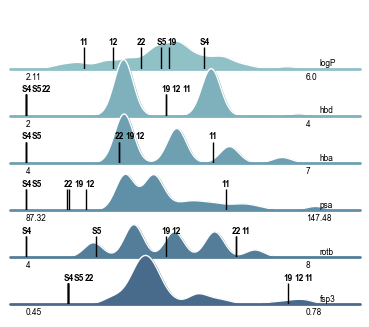

In [449]:
import seaborn as sns

df = pd.DataFrame(df2)

def label(x, color, label):
    ax = plt.gca()
    ax.text(3.3, 0.05, label, color="black", fontsize=6, fontfamily="arial")


sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)
pal = sns.cubehelix_palette(10, rot=-0.25, light=0.7)

g = sns.FacetGrid(
    df, row="attribute", hue="attribute", aspect=7, height=1.5, palette=pal
)

g.map(sns.kdeplot, "value", clip_on=True, fill=True, alpha=1, lw=1, bw_method=0.2)
g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=1, bw_method=0.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


def min_max_normalize(value, min_value, max_value, new_min, new_max):
    normalized_value = (value - min_value) / (max_value - min_value)
    scaled_value = normalized_value * (new_max - new_min) + new_min
    return scaled_value


axes = g.axes.flatten()
for i, ax in enumerate(axes):
    prev = []
    for idx2, i2 in enumerate(labeld_data):
        pp = min_max_normalize(i2[i], mins[i], maxs[i], -3, 3)
        ppt = pp - .1
        ax.vlines(pp, 0, 0.4, color="black", lw=1)
        close_prev = False
        v = 1
        val = 0
        for ppp in prev:
            if abs(ppt - ppp) < 0.3:
                close_prev = True
                val = ppp

        if close_prev:
            if prev[-1] < val:
                ppt = val + .225*v
            else:
                ppt = prev[-1] + .225*v
        ax.text(
            ppt,
            0.45,
            numbers[idx2],
            color="black",
            fontsize=6,
            fontfamily="arial",
            fontweight="bold",
        )
        prev.append(ppt)
    ax.text(
        -3, -0.2, str(round(mins[i], 2)), color="black", fontsize=6, fontfamily="arial"
    )
    ax.text(
        3, -0.2, str(round(maxs[i], 2)), color="black", fontsize=6, fontfamily="arial"
    )


g.map(label, "attribute")
g.despine(bottom=True, left=True)
g.fig.subplots_adjust(hspace=-0.2)
g.set_titles("")
g.set(yticks=[])
g.set(ylabel="")
g.set(xticks=[])
g.despine(bottom=True, left=True)
_ = g.axes[-1][0].set_xlabel("")

plt.gcf().set_size_inches(3.9, 3.5)

plt.savefig("EDF8 KDE.png", dpi=300, bbox_inches="tight", pad_inches=0.01)